# Importing libraries

In [1]:
# 1. Imports
import csv
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score
from albumentations import Compose as AlbCompose, Resize as AlbResize, Normalize as AlbNormalize
import matplotlib.pyplot as plt
from segmentation_models_pytorch import DeepLabV3Plus


In [2]:
# 2. Define Device and Model Initialization
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DeepLabV3Plus(encoder_name="resnet50", encoder_weights="imagenet", in_channels=3, classes=2)
model.to(device)


DeepLabV3Plus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequentia

In [3]:
# 3. Load the Model State

# load the model
def load_initial_model_state(model, filepath='initial_deeplab_model.pth'):
    model.load_state_dict(torch.load(filepath))
    model.eval()  # Set the model to evaluation mode
    print("Initial model state loaded!")

# Call the function to load the model state
    load_initial_model_state(model)


In [4]:
# Training Setup Variables
num_epochs = 50
learning_rate = 0.001
improvement_tolerance = 0.0001
patience = 3
criterion = nn.CrossEntropyLoss()

# Metric tracking dictionaries for augmented and non-augmented data
metric_lists = {
    "augmented": {
        "train_losses": [], "test_losses": [], "train_accuracies": [], "test_accuracies": [],
        "train_jaccards": [], "test_jaccards": [], "train_precisions": [], "test_precisions": [],
        "train_recalls": [], "test_recalls": [], "train_dices": [], "test_dices": []
    },
    "non_augmented": {
        "train_losses": [], "test_losses": [], "train_accuracies": [], "test_accuracies": [],
        "train_jaccards": [], "test_jaccards": [], "train_precisions": [], "test_precisions": [],
        "train_recalls": [], "test_recalls": [], "train_dices": [], "test_dices": []
    }
}

# # For augmented data
# train_losses_augmented, test_losses_augmented = [], []
# train_accuracies_augmented, test_accuracies_augmented = [], []
# train_jaccards_augmented, test_jaccards_augmented = [], []
# train_precisions_augmented, test_precisions_augmented = [], []
# train_recalls_augmented, test_recalls_augmented = [], []
# train_dices_augmented, test_dices_augmented = [], []

# # For non-augmented data
# train_losses_non_augmented, test_losses_non_augmented = [], []
# train_accuracies_non_augmented, test_accuracies_non_augmented = [], []
# train_jaccards_non_augmented, test_jaccards_non_augmented = [], []
# train_precisions_non_augmented, test_precisions_non_augmented = [], []
# train_recalls_non_augmented, test_recalls_non_augmented = [], []
# train_dices_non_augmented, test_dices_non_augmented = [], []



**Step 5: Data Transformations (Updated for Experiment 2)**

We define the `get_transforms()` function with a new `augment` parameter to support optional data augmentations. If `augment=True`, additional transformations are applied:
- **Horizontal Flip**: Flips images horizontally with a 50% probability.
- **Random Rotate 90**: Rotates images by 90 degrees at random (50% chance).
- **Random Brightness/Contrast**: Adjusts brightness and contrast randomly with a 20% chance.
- **Gaussian Blur**: Applies a random Gaussian blur with a 20% chance.

These augmentations enhance the dataset diversity and can help improve model generalization.


In [5]:
from albumentations import HorizontalFlip, RandomRotate90, RandomBrightnessContrast, GaussianBlur

# 5 Updated get_transforms function with specific augmentation selection
def get_transforms(augmentation_type=None):
    base_transforms = [
        AlbResize(height=256, width=256, interpolation=1),
        AlbNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    ]
    
    # Define individual augmentations
    augmentations = {
        'Horizontal Flip': HorizontalFlip(p=0.5),
      # 'Random Rotate 90': RandomRotate90(p=0.5),
        'Brightness/Contrast': RandomBrightnessContrast(p=0.2),
        'Gaussian Blur': GaussianBlur(blur_limit=(3, 7), p=0.2)
    }
    
    # Apply the selected augmentation if specified
    if augmentation_type in augmentations:
        return AlbCompose([augmentations[augmentation_type]] + base_transforms)
    else:
        return AlbCompose(base_transforms)  # Only base transforms if no augmentation specified


In [6]:
# 6 Updated KvasirDataset class with augmentation selection
class KvasirDataset(Dataset):
    def __init__(self, images_dir, masks_dir, file_list, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        with open(file_list, 'r') as f:
            self.image_filenames = f.read().splitlines()

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image = Image.open(os.path.join(self.images_dir, self.image_filenames[idx] + '.jpg')).convert("RGB")
        mask = Image.open(os.path.join(self.masks_dir, self.image_filenames[idx] + '.png')).convert("L")

        # Convert images to numpy arrays
        image_np = np.array(image)
        mask_np = np.array(mask)

        # Apply transformations
        if self.transform:
            augmented = self.transform(image=image_np, mask=mask_np)
            image, mask = augmented['image'], augmented['mask']

        mask = (mask > 0).astype(np.int64)  # Convert mask to binary (0 or 1)

        # Convert to PyTorch tensors
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)
        mask = torch.tensor(mask, dtype=torch.long)

        return image, mask


**Step 7: Load Datasets and Define Data Loaders (Updated for Experiment 2)**

We create separate data loaders for training with and without augmentation:
- **No Augmentation**: Uses `get_transforms(augment=False)` to apply only resizing and normalization.
- **With Augmentation**: Uses `get_transforms(augment=True)` to apply resizing, normalization, and additional augmentations.

This allows us to evaluate model performance under each condition and measure the impact of data augmentation.


In [7]:
# 7 Non-Augmented Data Loader
print("Training with No Augmentation")
train_loader_no_aug = DataLoader(
    KvasirDataset('kvasir-instrument/images/', 'kvasir-instrument/masks/', 'kvasir-instrument/train.txt', 
    transform=get_transforms()), 
    batch_size=8, shuffle=True
)

# Augmented Data Loaders - for each augmentation
augmentation_types = ['Horizontal Flip', 'Brightness/Contrast', 'Gaussian Blur']
train_loaders = {aug: DataLoader(
                    KvasirDataset('kvasir-instrument/images/', 'kvasir-instrument/masks/', 'kvasir-instrument/train.txt',
                                  transform=get_transforms(augmentation_type=aug)),
                    batch_size=8, shuffle=True
                 ) for aug in augmentation_types}

# Test Data Loader (Non-Augmented)
test_loader = DataLoader(
    KvasirDataset('kvasir-instrument/images/', 'kvasir-instrument/masks/', 'kvasir-instrument/test.txt', 
    transform=get_transforms()), 
    batch_size=8, shuffle=False
)

# Define train_dataset_no_aug by accessing the dataset from the DataLoader
train_dataset_no_aug = train_loader_no_aug.dataset

Training with No Augmentation


In [8]:
# 8 Training Loop
def calculate_accuracy(preds, targets):
    correct = (preds == targets).float()
    accuracy = correct.sum() / correct.numel()
    return accuracy

def calculate_metrics(preds, targets):
    preds_flat = preds.flatten()
    targets_flat = targets.flatten()
    jaccard = jaccard_score(targets_flat, preds_flat, average='binary')
    precision = precision_score(targets_flat, preds_flat, zero_division=0)
    recall = recall_score(targets_flat, preds_flat, zero_division=0)
    accuracy = (preds_flat == targets_flat).sum() / len(targets_flat)
    dice = f1_score(targets_flat, preds_flat, average='binary')
    return jaccard, precision, recall, accuracy, dice


**Training and Evaluation Function** (For experiment 2)
- This function trains and evaluates the) model, with a parameter `(is_augmented)` to differentiate between augmented and non-augmented data. Key changes include:

- Separate Metric Tracking: Maintains separate lists for metrics (loss, accuracy, Jaccard, precision, recall, and dice score) for both augmented and non-augmented runs. This allows for easy comparison between the two setups.

- Early Stopping and Checkpointing: Stops training if there is no improvement in test loss after a set number of epochs (patience). Saves the model when a new best test loss is reached.

- Returns: All metrics are returned for either the augmented or non-augmented datasets, based on the training condition.

In [9]:
import csv

# 9 Training function with early stopping and CSV logging
def train_and_evaluate(model, train_loader, test_loader, augmentation_name):
    best_test_loss = float('inf')
    early_stop_counter = 0
    csv_filename = 'Exp_2_Metrics.csv'

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    # Write CSV header if file does not exist
    if not os.path.isfile(csv_filename):
        with open(csv_filename, mode='w', newline='') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow([
                "Augmentation", "Epoch", "Train Loss", "Test Loss", "Train Accuracy", "Test Accuracy",
                "Train Jaccard", "Test Jaccard", "Train Precision", "Test Precision",
                "Train Recall", "Test Recall", "Train Dice", "Test Dice"
            ])

    for epoch in range(num_epochs):
        model.train()
        running_loss, running_acc = 0.0, 0.0
        all_train_jaccard, all_train_precision, all_train_recall, all_train_dice = [], [], [], []

        for images, masks in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            preds = torch.argmax(outputs, dim=1)
            running_loss += loss.item()
            running_acc += calculate_accuracy(preds, masks).item()

            # Calculate training metrics
            jaccard, precision, recall, _, dice = calculate_metrics(preds.cpu().numpy(), masks.cpu().numpy())
            all_train_jaccard.append(jaccard)
            all_train_precision.append(precision)
            all_train_recall.append(recall)
            all_train_dice.append(dice)

        # Log training metrics
        avg_train_loss = running_loss / len(train_loader)
        avg_train_acc = running_acc / len(train_loader)
        avg_train_jaccard = sum(all_train_jaccard) / len(all_train_jaccard)
        avg_train_precision = sum(all_train_precision) / len(all_train_precision)
        avg_train_recall = sum(all_train_recall) / len(all_train_recall)
        avg_train_dice = sum(all_train_dice) / len(all_train_dice)

        # Validation/Test Step
        model.eval()
        with torch.no_grad():
            running_test_loss, running_test_acc = 0.0, 0.0
            all_jaccard, all_precision, all_recall, all_accuracy, all_dice = [], [], [], [], []

            for images, masks in test_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                test_loss = criterion(outputs, masks)
                running_test_loss += test_loss.item()

                preds = torch.argmax(outputs, dim=1)
                jaccard, precision, recall, accuracy, dice = calculate_metrics(preds.cpu().numpy(), masks.cpu().numpy())
                all_jaccard.append(jaccard)
                all_precision.append(precision)
                all_recall.append(recall)
                all_accuracy.append(accuracy)
                all_dice.append(dice)

            # Average metrics
            avg_test_loss = running_test_loss / len(test_loader)
            avg_test_acc = sum(all_accuracy) / len(all_accuracy)
            avg_jaccard = sum(all_jaccard) / len(all_jaccard)
            avg_precision = sum(all_precision) / len(all_precision)
            avg_recall = sum(all_recall) / len(all_recall)
            avg_dice = sum(all_dice) / len(all_dice)

            # Log metrics to CSV
            with open(csv_filename, mode='a', newline='') as csvfile:
                writer = csv.writer(csvfile)
                writer.writerow([
                    augmentation_name, epoch + 1, avg_train_loss, avg_test_loss, avg_train_acc, avg_test_acc,
                    avg_train_jaccard, avg_jaccard, avg_train_precision, avg_precision,
                    avg_train_recall, avg_recall, avg_train_dice, avg_dice
                ])

            # Check for early stopping with improvement tolerance
            if avg_test_loss < best_test_loss - improvement_tolerance:
                best_test_loss = avg_test_loss
                early_stop_counter = 0
                torch.save({
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'epoch': epoch + 1,
                    'test_loss': avg_test_loss,
                    'test_accuracy': avg_test_acc,
                    'jaccard': avg_jaccard,
                    'precision': avg_precision,
                    'recall': avg_recall,
                    'dice': avg_dice
                }, 'Exp_2.pth')
                print("Best model saved!")
            else:
                early_stop_counter += 1
                if early_stop_counter >= patience:
                    print(f"Early stopping at epoch {epoch + 1} due to lack of improvement.")
                    break

        scheduler.step()


**Step 12: Run Training and Evaluation (Added for Experiment 2)**

We call the `train_and_evaluate` function twice:
- **Without Augmentation**: Using `train_loader_no_aug` to measure baseline performance.
- **With Augmentation**: Using `train_loader_aug` to measure performance with data augmentation.

By running both setups, we can observe how data augmentation impacts the model’s performance metrics.


In [10]:
# 10. Run Training and Evaluation

# First, evaluate with no augmentation
print("Training with No Augmentation")
train_and_evaluate(model, train_loader_no_aug, test_loader, augmentation_name="None")

# Now, evaluate with each augmentation type
for aug_name, train_loader_aug in train_loaders.items():
    print(f"Training with {aug_name} Augmentation")
    train_and_evaluate(model, train_loader_aug, test_loader, augmentation_name=aug_name)


Training with No Augmentation


Epoch 1/50: 100%|██████████| 59/59 [03:11<00:00,  3.25s/it]


Best model saved!


Epoch 2/50: 100%|██████████| 59/59 [02:56<00:00,  2.99s/it]


Best model saved!


Epoch 3/50: 100%|██████████| 59/59 [02:52<00:00,  2.93s/it]


Best model saved!


Epoch 4/50: 100%|██████████| 59/59 [02:53<00:00,  2.95s/it]


Best model saved!


Epoch 7/50: 100%|██████████| 59/59 [02:55<00:00,  2.98s/it]


Early stopping at epoch 7 due to lack of improvement.
Training with Horizontal Flip Augmentation


Epoch 1/50: 100%|██████████| 59/59 [02:52<00:00,  2.92s/it]


Best model saved!


Epoch 3/50: 100%|██████████| 59/59 [02:55<00:00,  2.98s/it]


Best model saved!


Epoch 6/50: 100%|██████████| 59/59 [02:58<00:00,  3.03s/it]


Best model saved!


Epoch 8/50: 100%|██████████| 59/59 [02:53<00:00,  2.94s/it]


Best model saved!


Epoch 10/50: 100%|██████████| 59/59 [02:53<00:00,  2.95s/it]


Best model saved!


Epoch 13/50: 100%|██████████| 59/59 [02:52<00:00,  2.92s/it]


Early stopping at epoch 13 due to lack of improvement.
Training with Brightness/Contrast Augmentation


Epoch 1/50: 100%|██████████| 59/59 [02:51<00:00,  2.90s/it]


Best model saved!


Epoch 2/50: 100%|██████████| 59/59 [02:51<00:00,  2.91s/it]


Best model saved!


Epoch 4/50: 100%|██████████| 59/59 [02:53<00:00,  2.93s/it]


Best model saved!


Epoch 7/50: 100%|██████████| 59/59 [02:50<00:00,  2.90s/it]


Best model saved!


Epoch 8/50: 100%|██████████| 59/59 [02:50<00:00,  2.88s/it]


Best model saved!


Epoch 10/50: 100%|██████████| 59/59 [02:50<00:00,  2.89s/it]


Best model saved!


Epoch 13/50: 100%|██████████| 59/59 [02:50<00:00,  2.89s/it]


Early stopping at epoch 13 due to lack of improvement.
Training with Gaussian Blur Augmentation


Epoch 1/50: 100%|██████████| 59/59 [02:51<00:00,  2.90s/it]


Best model saved!


Epoch 4/50: 100%|██████████| 59/59 [02:50<00:00,  2.90s/it]


Early stopping at epoch 4 due to lack of improvement.


# Visualizing Augmentations with Denormalization

This code displays sample images with different augmentations applied, helping us verify that the transformations are working as intended.

**`denormalize(image)`:**

Reverses the normalization applied to images during training. This makes colors appear natural for visualization.

**`visualize_individual_augmentations(dataset, num_images=3)`:**

Shows the original image alongside augmented versions with labels for each transformation.

**Augmentations:**

*   **Horizontal Flip:** Flips the image horizontally.
*   **Brightness/Contrast:** Adjusts the brightness and contrast.
*   **Gaussian Blur:** Blurs the image to simulate out-of-focus conditions.

Each augmentation is applied independently, making it easy to observe its effect.

This setup allows us to see how each augmentation changes the images, ensuring that the data pipeline matches expectations before training.

Images with individual augmentations applied:


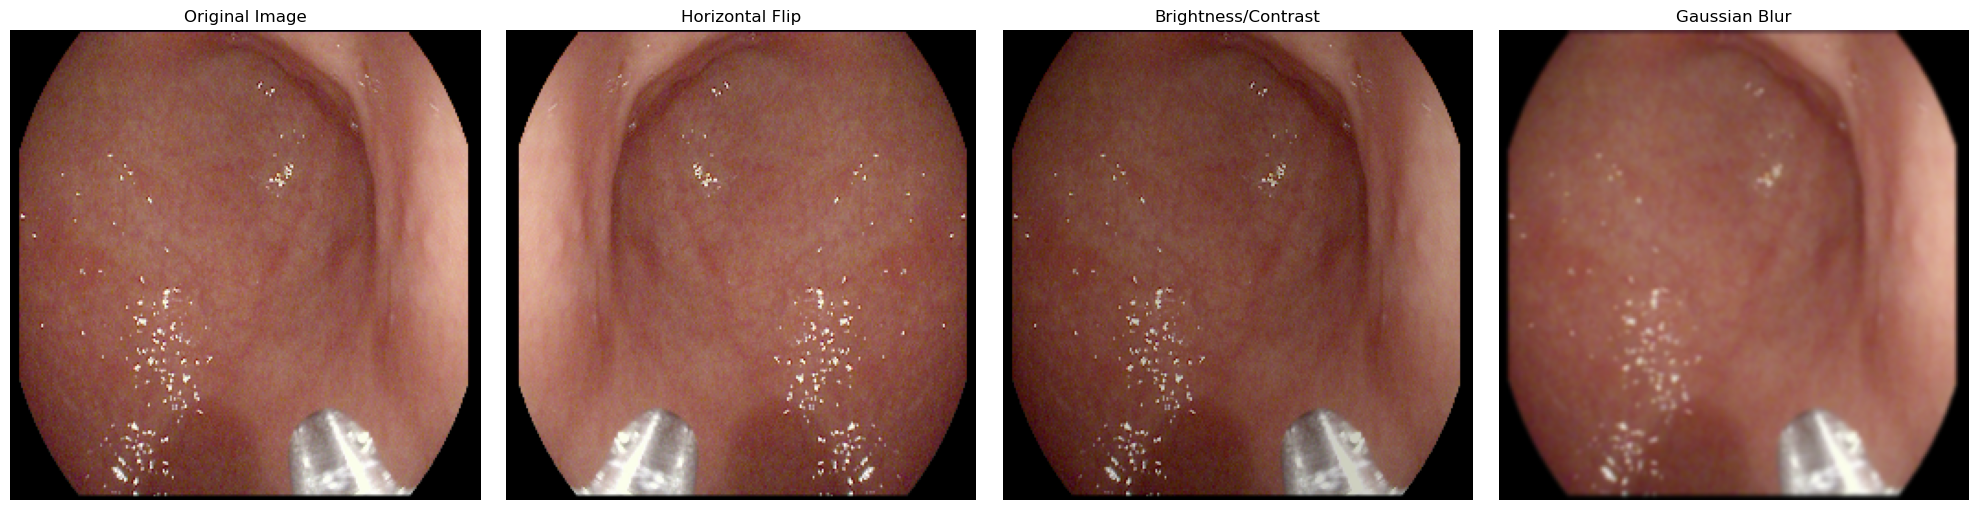

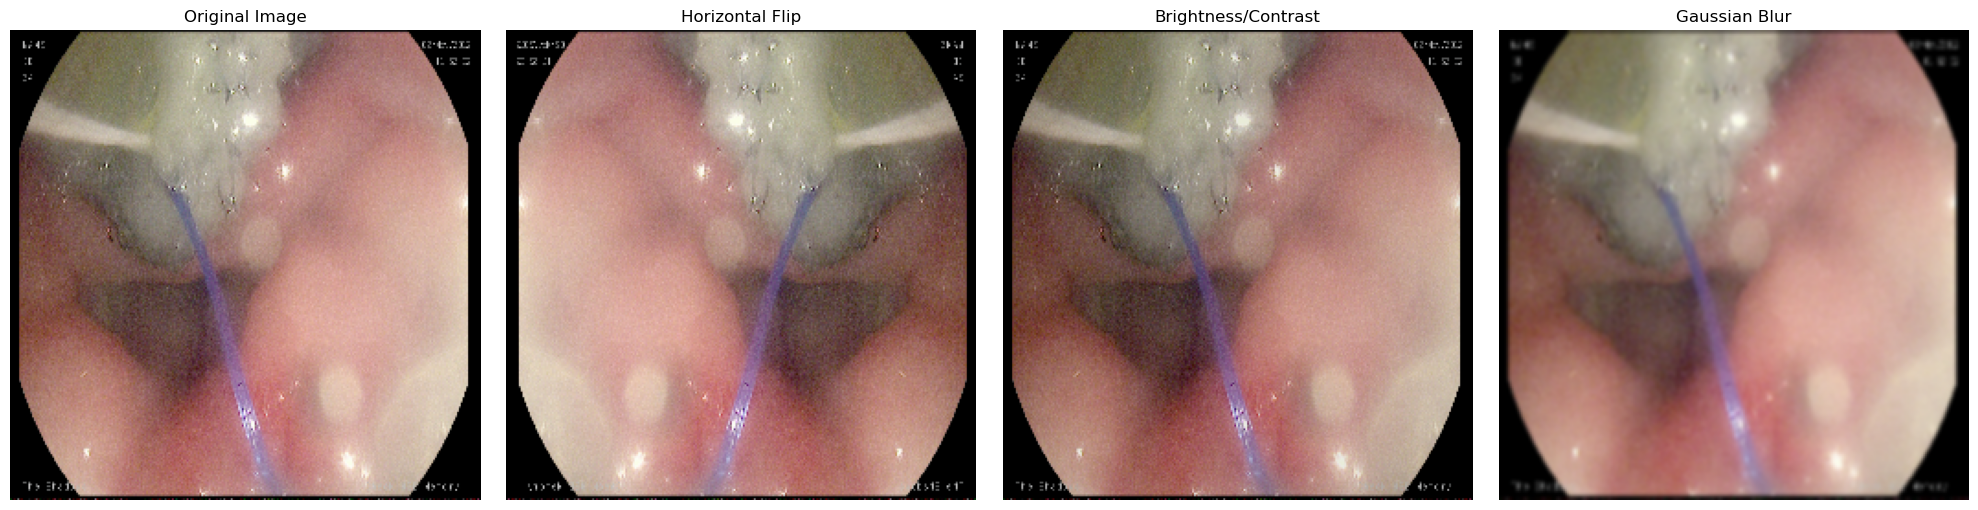

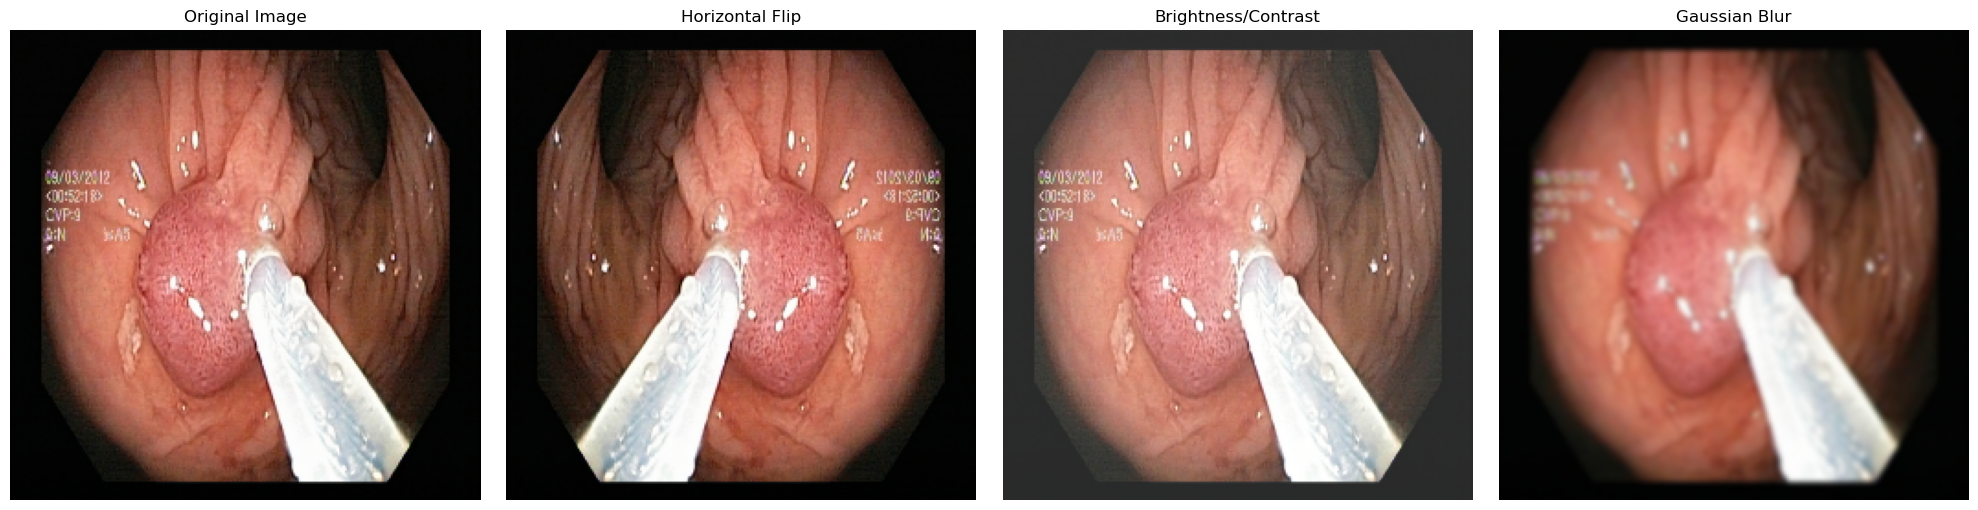

In [11]:
from albumentations import Compose, HorizontalFlip, RandomRotate90, RandomBrightnessContrast, GaussianBlur
import numpy as np
import matplotlib.pyplot as plt

def denormalize(image_np):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image_np = image_np * std + mean
    return image_np

def visualize_individual_augmentations(dataset, num_images=3):
    """
    Displays original images and augmented versions with labels for specific augmentations.
    
    Parameters:
    - dataset: An instance of KvasirDataset with transformations applied.
    - num_images: Number of images to display.
    """
    # Define individual augmentations
    augmentations = [
        ("Horizontal Flip", Compose([HorizontalFlip(p=1.0)])),
        ("Brightness/Contrast", Compose([RandomBrightnessContrast(p=1.0)])),
        ("Gaussian Blur", Compose([GaussianBlur(blur_limit=(3, 7), p=1.0)]))
    ]
    
    for idx in range(num_images):
        # Get an image and mask from the dataset without any transformations
        image, _ = dataset[idx]
        image_np = image.permute(1, 2, 0).numpy()  # Convert to HWC format for display
        
        # Denormalize the image for display
        image_np = denormalize(image_np)
        image_np = (image_np * 255).astype(np.uint8)  # Convert to uint8 for display

        # Set up a 1x4 grid: 1 original + 3 augmented images per row
        fig, axes = plt.subplots(1, 4, figsize=(20, 5))
        
        # Show original image
        axes[0].imshow(image_np)
        axes[0].set_title("Original Image")
        axes[0].axis('off')
        
        # Apply each augmentation and display
        for j, (aug_name, aug_transform) in enumerate(augmentations, start=1):
            augmented = aug_transform(image=image_np)['image']
            axes[j].imshow(augmented)
            axes[j].set_title(aug_name)
            axes[j].axis('off')
        
        plt.tight_layout()
        plt.show()

# Visualize individual augmentations on a few sample images
print("Images with individual augmentations applied:")
visualize_individual_augmentations(train_dataset_no_aug)